# No Training Required: Exploring Random Encoders for Sentence Classification<sup>#</sup>

### Authors: John Wieting (Carnegie Mellon University), Douwe Kiela (Facebook AI Research)


Paper walkthrough by Armin Catovic, Sr. Data Scientist, Schibsted

<sub><sup>#</sup> Published as a conference paper at ICLR 2019</sub>

## Background

* Fully encoding the meaning of sentences and documents into a compact vector representation (embedding) is the Holy Grail of NLP
* Such representations can be used to both compute semantic similarity between text, as well as used in downstream classification tasks such as sentiment analysis
* There is currently no clear consesus on how much explicitly trained sentence-encoding architectures (e.g. skip-thought vectors) improve over the raw word embeddings (e.g. GloVe)

## Approach

* Encode a sentence by performing a non-linear transformation of pre-trained word embeddings to a randomly initialized higher dimensional space, followed by a simple pooling mechanism - in other words, don't perform any parameter updates whatsoever
* Compare such "random sentence encoders" to state-of-the-art (SOTA) explicitly trained sentence-encoding architectures, across a range of classification and correlation tasks

## Motivation

* Provide a more scientifically grounded baseline for sentence encodings
* Attempt to understand contributing factors in observed results 

<sub>NOTE: At the time of writing, SOTA sentence encoders were implemented via RNN based architectures - no comparisons were made against Transformer based models.</sub>

## Hypotheses

* Pre-trained word embeddings (e.g. word2vec, GloVe) do most of the heavy lifting - simple pooling mechanisms (e.g. mean pooling) can be used to then fairly accurately encode sentence representations
* Cover's theorem (non-linear projections to higher-dimensional space) can be exploited to further improve the performance of downstream classification and correlation tasks
* RNN based architectures such as LSTMs and ESNs "encode priors that are intrinsically good for sentence representations"

## Biological Comparisons

* In fruit fly's olfactory system, ~50 projection neurons (PNs) are projected to ~2500 Kenyon cells (KCs), with only 10% of KCs being activated (via winner-takes-all inhibition process)
* Similar projection and sparsity is also seen in rodent olfactory circuit, as well as in rat's cerebellum and hippocampus

<sub>We can draw these comparisons to Cover's Theorem and inherent sparsity in ESNs. The main difference is that in biological mechanisms, the stimuli are encoded as sparse binary representations, as opposed to continuous. These details are not referenced in the paper. For more details, see "Bio-inspired Hashing for Unsupervised Similarity Search", by C. K. Ryali et al, and "Can a Fruit Fly Learn Word Embeddings" by Y. Liang et al.</sub>

## Cover's Theorem

* Theorem postulated by information theorist Thomas Cover, who is also famous for developing k-nearest neighbors (k-NN) algorithm
* Provides basis for kernel methods, most notably used in support vector machines (SVM)

> A complex pattern-classification problem, cast in a high-dimensional space nonlinearly, is more likely to be linearly separable than in a low-dimensional space, provided that the space is not densely populated.

<sub>For details refer to "Geometrical and Statistical Properties of Systems of Linear Inequalities with Applications in Pattern Recognition", Thomas M. Cover</sub>

In [14]:
# Global imports

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
import torch
import torch.nn as nn

In [2]:
# Generate an "interesting" synthetic dataset

X, y = make_circles(
    n_samples=1_000, 
    shuffle=True, 
    noise=0.05,
    factor=0.5,
    random_state=42
)

print(X)

[[ 0.45259239  0.16843331]
 [-0.43802652  0.11990049]
 [-0.5322243   0.18435902]
 ...
 [-0.07201617 -0.531447  ]
 [ 0.66090453 -0.79319015]
 [ 0.27841491  0.96735953]]


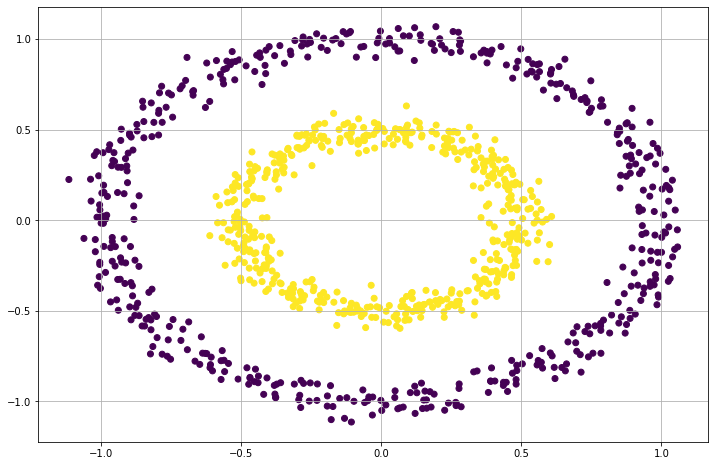

In [4]:
# Plot in 2d - impossible to do clean linear separation

plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.grid()
plt.show()

In [5]:
# Implement a kernel method with a deterministic mapping from 2-d to 3-d

def phi_transform(X: np.ndarray) -> np.ndarray:
    """Assuming `X` is a 2d array of shape (n_samples, 2)"""
    X_phi = np.zeros((X.shape[0], 3))
    X_phi[:, :2] = X
    X_phi[:, 2] = X[:, 0]**2 + X[:, 1]**2
    return X_phi

In [6]:
X_phi = phi_transform(X)
print(X_phi)

[[ 0.45259239  0.16843331  0.23320965]
 [-0.43802652  0.11990049  0.20624336]
 [-0.5322243   0.18435902  0.31725096]
 ...
 [-0.07201617 -0.531447    0.28762225]
 [ 0.66090453 -0.79319015  1.06594541]
 [ 0.27841491  0.96735953  1.01329932]]


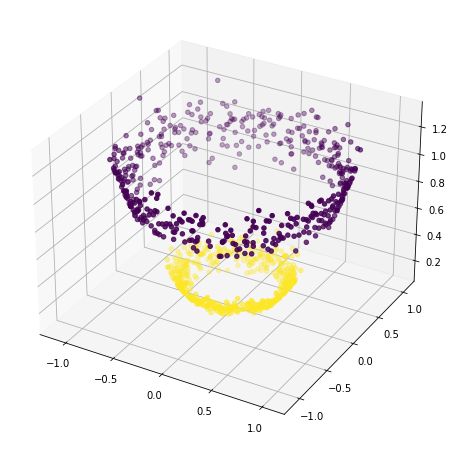

In [7]:
# Plot the projected data in 3d - now we can achieve perfect separation using a horizontal plane

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_phi[:, 0], X_phi[:, 1], X_phi[:, 2], c=y)
ax.view_init(30)
plt.grid()
plt.show()

## Random Sentence Encoders

* __Bag of Random Embedding Projections (BOREP)__
  * Essentially a dot-product followed by a ReLU activation function<sup>#</sup>
  * Sentence representation $h = f_{pool}(\phi(We_i))$, where $W \sim  Uniform(\frac{-1}{\sqrt{d}}, \frac{1}{\sqrt{d}})$, $W \in \mathbb{R}^{D x d}$, $D$ is the target dimension, $d$ is the word vector dimension, $e_i$ is the word vector, $\phi(x)$ is an activation function (generally a ReLU), and $f_{pool}$ is some pooling function, generally a mean, $\Sigma(x)$


* __Random Long-Short Term Memory (LSTM)__
  * Bi-directional LSTM with weights and biases initialized using $Uniform(\frac{-1}{\sqrt{d}}, \frac{1}{\sqrt{d}})$
  * Sentence representation $h = f_{pool}(BiLSTM(e_1, ..., e_n))$

* __Echo State Network (ESN)__
  * ESN is a type of RNN that constitutes a _reservoir computing_ paradigm, with fixed random projections and sparsity being two of its intrinsic properties
  * Bidirectional ESN with max pooling is used, which yields a sentence representation $h = max(ESN(e_1, ..., e_n))$

<sub><sup>#</sup> In the paper, BOREP is actually represented as a linear transformation, but in their GitHub repo (https://github.com/facebookresearch/randsent) they do indeed use an activation function, thereby making it a non-linear transformation in accordance with Cover's Theorem.

In [9]:
# Implement a random projector that forms the core of the BOREP encoder.
# Demonstrate on the previously generate toy dataset

class UniformRandomProjector(nn.Module):
    def __init__(self, input_dim: int, output_dim: int) -> None:
        super(UniformRandomProjector, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        limit = 1.0/np.sqrt(input_dim)
        self.proj = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()
        nn.init.uniform_(self.proj.weight, a=-limit, b=limit)
        nn.init.constant_(self.proj.bias, 0)
    
    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        n_samples = x.size(0)
        out = torch.FloatTensor(n_samples, self.output_dim).zero_()
        for i in range(n_samples):
            out[i] = self.proj(x[i])
        out = self.activation(out)
        return out
    
    def encode(self, x: torch.FloatTensor) -> np.ndarray:
        return self.forward(x).detach().numpy()

In [19]:
torch.manual_seed(0)
proj = UniformRandomProjector(2, 3)
X_hat = proj.encode(torch.FloatTensor(X))
print(X_hat)

[[0.04869058 0.         0.        ]
 [0.         0.         0.17018035]
 [0.         0.         0.19550483]
 ...
 [0.10009369 0.36901993 0.1886347 ]
 [0.2931637  0.44396552 0.        ]
 [0.         0.         0.        ]]


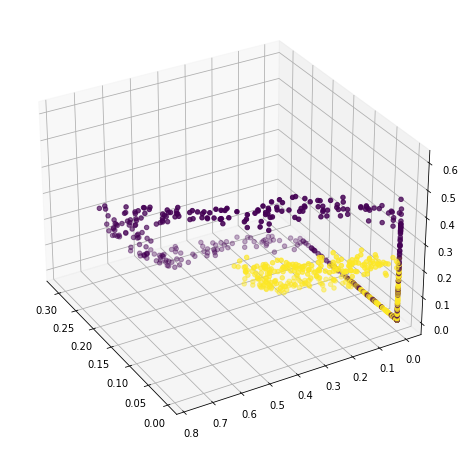

In [20]:
# Even with a non-linear uniform random projection,
# we can now achieve a pretty good linear separation in 3-d

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=y)
ax.view_init(30, 150)
plt.grid()
plt.show()

## Evaluation

* Random sentence encoders are compared against SkipThought (Kiros et al., 2015) and InferSent (Conneau et al., 2017) - the former is an unsupervised model requiring several weeks of training, and the latter is a supervised method leveraging huge amount of annotated data
* Random encoders are thoroughly probed for stability
* The target dimension of random encoders is 4096, but higher dimensions are also evaluated, up to 6x4096 dimensions
* SentEval (Conneau & Kiela, 2018) benchmark is used, where logistic regression is used across a number of downstream tasks, taking into account classification accuracy:
  * Sentiment analysis (MR, SST)
  * Question-type (TREC)
  * Product reviews (CR)
  * Subjectivity (SUBJ)
  * Opinion polarity (MPQA)
  * Paraphrasing (MRPC)
  * Entailment (SICK-E, SNLI)
  * Semantic relatedness (SICK-R, STSB)<sup>#</sup>

<sub><sup>#</sup>Semantic relatedness are treated as correlation tasks, and Pearson's $r$ score is used during evaluation</sub>

## Results - Random Encoder Accuracy in 4096 Dimensions

![Table 1 Results](./figures/randsent_table_1.PNG "Table 1 Results")

## Results - Random Encoder Accuracy vs Dimension Size

![Figure 1 Results](./figures/randsent_fig_1.PNG "Figure 1 Results")

## Results - Random Encoder Accuracy in 24K Dimensions

![Table 2 Results](./figures/randsent_table_2.PNG "Table 2 Results")

## Sentence Probing Tasks

* Number of probing tasks are evaluated as per Conneau et al (2018), in order to ascertain the linguistic properties of sentence embeddings
  * Surface information (SentLen, WC)
  * Syntactic information (BShift, TreeDepth, TopConst)
  * Semantic information (Tense, SubjNum, ObjNum, SOMO, CoordInv)

## Results - Sentence Probing Tasks

![Table 3 Results](./figures/randsent_table_3.PNG "Table 3 Results")

## Discussion and Conclusion

* Across all tasks, the performance improvement of large explicitly-trained sentence encoders is less than 2 percentage points on average, over simple random projections
* Since all methods use pre-trained word embeddings, this validates the hypothesis that almost all the heavy lifting in sentence representations is done by word embeddings
* Non-linear random projections to higher dimensions always yields better results, validating Cover's theorem
* Explicitly trained sentence encoders (and particularly SkipThought) seem to predominantly learn grammatical structure, such as word ordering
* ESNs seem to have intrinsically good properties for encoding sentences
* It would be interesting to compare against fine-tuned Transformer architectures
* It would be interesting to apply random projections using Transformer architectures
* It would be interesting to train GloVe vectors with high dimensionality (e.g. >= 4096)

## Personal Reflections on the Paper

* Very clearly and unambiguously written
* The code in GitHub very nearly represents the contents of the paper
* The insights are very interesting and point at significantly more work needed in the space of sentence (and document) representations - perhaps this is partially achieved by Transformer/BERT based models?
* ESNs and reservoir computing seems super interesting!